In [8]:
# Install (if needed) and imports
!pip install -q tensorflow scikit-learn seaborn

import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# reproducible
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)


In [9]:
# Adjust path if needed; Colab uploaded file path is usually /content/...
file_candidates = [
    '/content/sonardataset (1).csv',
    '/content/sonardataset.csv',
    '/content/sonar.csv',
    '/content/sonardataset (1).txt'
]
file_path = None
for f in file_candidates:
    if os.path.exists(f):
        file_path = f
        break

if file_path is None:
    raise FileNotFoundError("Upload your dataset file to Colab files panel and re-run. Expected name like 'sonardataset (1).csv'")

df = pd.read_csv(file_path, header=None, skiprows=1)  # dataset often has no header, skip the first row
print("Raw shape:", df.shape)
display(df.head())

# According to description: 60 feature columns then label column (M/R)
n_cols = df.shape[1]
if n_cols >= 2:
    X = df.iloc[:, :-1].astype(float)
    y = df.iloc[:, -1].astype(str)
else:
    raise ValueError("Dataset doesn't look like SONAR format (expected >1 columns).")

print("\nFeatures shape:", X.shape)
print("Target example values:", y.unique())

Raw shape: (208, 61)


,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R



Features shape: (208, 60)
Target example values: ['R' 'M']


In [10]:
# Encode labels: M -> 1 (mine), R -> 0 (rock)
le = LabelEncoder()
y_enc = le.fit_transform(y)   # M -> 1, R -> 0
print("Label classes:", le.classes_)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (common: 80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.2, stratify=y_enc, random_state=seed
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Label classes: ['M' 'R']
Train size: (166, 60) Test size: (42, 60)


In [11]:
def build_model(input_dim, hidden_units=[32], lr=0.001, activation='relu'):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(input_dim,)))
    # add hidden layers
    for i, units in enumerate(hidden_units):
        model.add(layers.Dense(units, activation=activation, name=f'hidden_{i+1}'))
    model.add(layers.Dense(1, activation='sigmoid', name='output'))  # binary classification
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Small wrapper to train and return history and metrics
def train_and_evaluate(hidden_units=[32], lr=0.001, activation='relu', epochs=100, batch_size=16, verbose=0):
    model = build_model(X_train.shape[1], hidden_units=hidden_units, lr=lr, activation=activation)
    history = model.fit(X_train, y_train, validation_split=0.15, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # predictions
    y_pred_prob = model.predict(X_test).flatten()
    y_pred = (y_pred_prob >= 0.5).astype(int)
    # metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return model, history, {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}, y_pred, y_pred_prob


In [12]:
# Baseline configuration
baseline_cfg = {'hidden_units':[32], 'lr':0.001, 'activation':'relu', 'epochs':100, 'batch_size':16}
model_base, hist_base, metrics_base, y_pred_base, y_prob_base = train_and_evaluate(**baseline_cfg, verbose=1)

print("Baseline metrics:", metrics_base)
print("\nClassification report (baseline):")
print(classification_report(y_test, y_pred_base, target_names=le.classes_))


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4381 - loss: 0.7846 - val_accuracy: 0.7600 - val_loss: 0.5069
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6058 - loss: 0.6412 - val_accuracy: 0.8000 - val_loss: 0.4747
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7160 - loss: 0.5551 - val_accuracy: 0.8000 - val_loss: 0.4484
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8199 - loss: 0.4949 - val_accuracy: 0.8400 - val_loss: 0.4267
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8421 - loss: 0.4504 - val_accuracy: 0.9200 - val_loss: 0.4092
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8878 - loss: 0.4156 - val_accuracy: 0.8800 - val_loss: 0.3945
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9068 - loss: 0.3866 - val_accuracy: 0.8400 - val_loss: 0.3819
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9068 - loss: 0.3616 - val_accuracy: 0.8800 - val_loss: 0.37

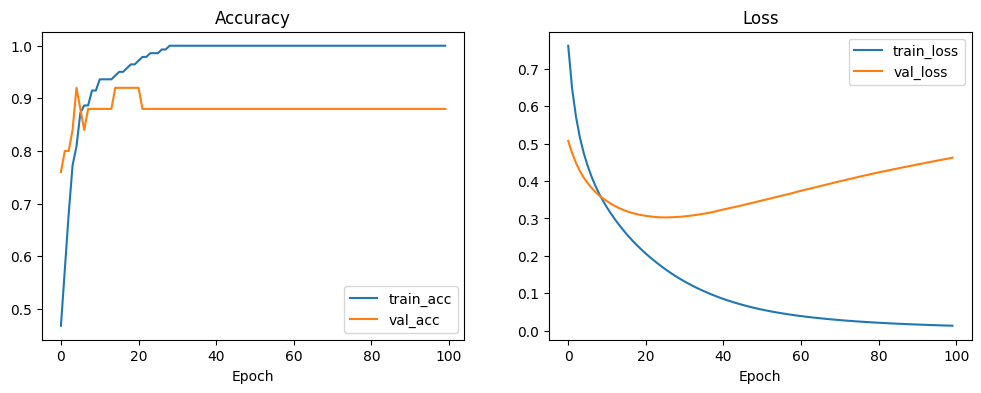

In [13]:
# Plot accuracy & loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist_base.history['accuracy'], label='train_acc')
plt.plot(hist_base.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_base.history['loss'], label='train_loss')
plt.plot(hist_base.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


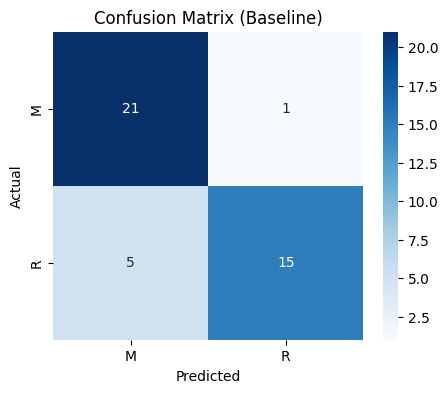

In [14]:
cm = confusion_matrix(y_test, y_pred_base)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Baseline)')
plt.show()


In [15]:
# Quick grid (small) — adjust if you want more runs (keeps training time reasonable)
grid = [
    {'hidden_units':[16], 'lr':0.01, 'activation':'relu'},
    {'hidden_units':[16], 'lr':0.001, 'activation':'relu'},
    {'hidden_units':[32], 'lr':0.01, 'activation':'relu'},
    {'hidden_units':[32], 'lr':0.001, 'activation':'relu'},
    {'hidden_units':[64], 'lr':0.001, 'activation':'relu'},
    {'hidden_units':[32,16], 'lr':0.001, 'activation':'relu'},
    {'hidden_units':[32,16], 'lr':0.001, 'activation':'tanh'},
]

results = []
for cfg in grid:
    print("Training:", cfg)
    model, hist, metrics, y_pred, y_prob = train_and_evaluate(
        hidden_units=cfg['hidden_units'], lr=cfg['lr'], activation=cfg['activation'],
        epochs=80, batch_size=16, verbose=0
    )
    row = {**cfg, **metrics}
    results.append(row)
    print(" ->", {k: f"{v:.4f}" for k,v in metrics.items()})

results_df = pd.DataFrame(results)
display(results_df.sort_values('f1', ascending=False))


Training: {'hidden_units': [16], 'lr': 0.01, 'activation': 'relu'}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
 -> {'accuracy': '0.8571', 'precision': '0.9375', 'recall': '0.7500', 'f1': '0.8333'}
Training: {'hidden_units': [16], 'lr': 0.001, 'activation': 'relu'}


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
 -> {'accuracy': '0.8095', 'precision': '0.8750', 'recall': '0.7000', 'f1': '0.7778'}
Training: {'hidden_units': [32], 'lr': 0.01, 'activation': 'relu'}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
 -> {'accuracy': '0.9048', 'precision': '0.9444', 'recall': '0.8500', 'f1': '0.8947'}
Training: {'hidden_units': [32], 'lr': 0.001, 'activation': 'relu'}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
 -> {'accuracy': '0.8333', 'precision': '0.8824', 'recall': '0.7500', 'f1': '0.8108'}
Training: {'hidden_units': [64], 'lr': 0.001, 'activation': 'relu'}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
 -> {'accuracy': '0.8333', 'precision': '0.8824', 'recall': '0.7500', 'f1': '0.8108'}
Training: {'hidden_units': [32, 16], 'lr': 0.001, 'activation': 'relu'}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
 -> {'accuracy': '0.8095', 'precision': '0.9286', 'recall': '0.6500', 'f1': '0.7647'}
Training: {'hidden_units': [32, 16], 'lr': 0.001, 'activation': 'tanh'}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/

,hidden_units,lr,activation,accuracy,precision,recall,f1
2,[32],0.010,relu,0.904762,0.944444,0.85,0.894737
0,[16],0.010,relu,0.857143,0.937500,0.75,0.833333
3,[32],0.001,relu,0.833333,0.882353,0.75,0.810811
4,[64],0.001,relu,0.833333,0.882353,0.75,0.810811
6,"[32, 16]",0.001,tanh,0.833333,0.933333,0.70,0.800000
1,[16],0.001,relu,0.809524,0.875000,0.70,0.777778
5,"[32, 16]",0.001,relu,0.809524,0.928571,0.65,0.764706


In [16]:
# choose best by f1 from grid (or baseline if you prefer)
best_idx = results_df['f1'].idxmax()
best_cfg = results_df.loc[best_idx]
print("Best config from grid:", best_cfg.to_dict())

# Re-train best model with more epochs
best_hidden = eval(best_cfg['hidden_units']) if isinstance(best_cfg['hidden_units'], str) else best_cfg['hidden_units']
# If saved as list object already (depends on display), ensure conversion:
if isinstance(best_hidden, str):
    best_hidden = eval(best_hidden)

model_best, hist_best, metrics_best, y_pred_best, y_prob_best = train_and_evaluate(
    hidden_units=best_hidden, lr=float(best_cfg['lr']), activation=best_cfg['activation'],
    epochs=150, batch_size=16, verbose=1
)

print("\nFinal metrics (best):", metrics_best)
print(classification_report(y_test, y_pred_best, target_names=le.classes_))


Best config from grid: {'hidden_units': [32], 'lr': 0.01, 'activation': 'relu', 'accuracy': 0.9047619047619048, 'precision': 0.9444444444444444, 'recall': 0.85, 'f1': 0.8947368421052632}
Epoch 1/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5408 - loss: 0.9062 - val_accuracy: 0.7200 - val_loss: 0.5088
Epoch 2/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8370 - loss: 0.3802 - val_accuracy: 0.8000 - val_loss: 0.3744
Epoch 3/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9134 - loss: 0.2458 - val_accuracy: 0.8800 - val_loss: 0.3665
Epoch 4/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9821 - loss: 0.1674 - val_accuracy: 0.8800 - val_loss: 0.3659
Epoch 5/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9916 - loss: 0.1140 - val_accuracy: 0.8800 - val_loss: 0.3518
Epoch 6/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9986 - loss: 0.0808 - val_accuracy: 0.8800 - val_loss: 0.3625
Epoch 7/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1

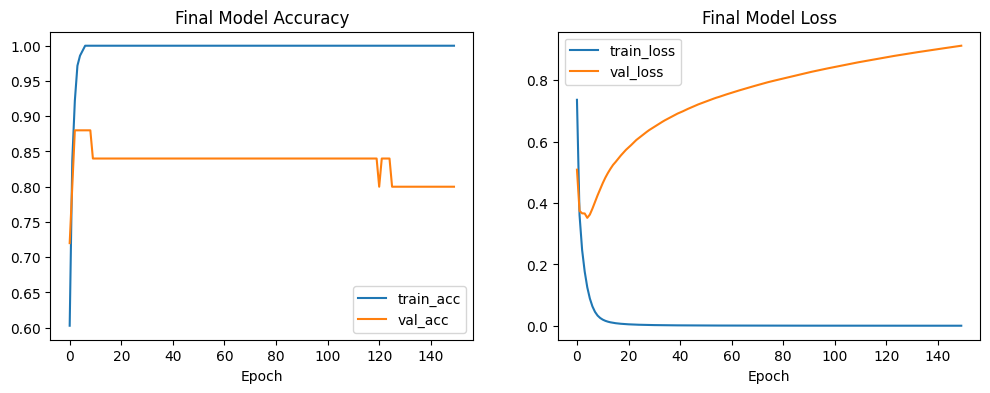

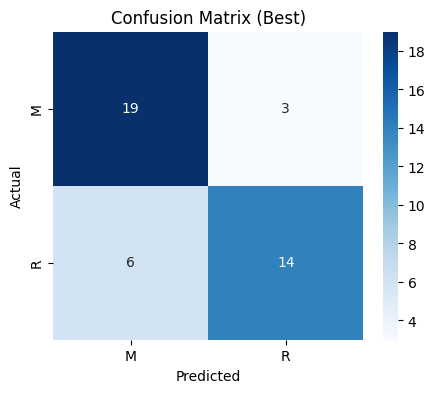

In [17]:
# final plots
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist_best.history['accuracy'], label='train_acc')
plt.plot(hist_best.history['val_accuracy'], label='val_acc')
plt.title('Final Model Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_best.history['loss'], label='train_loss')
plt.plot(hist_best.history['val_loss'], label='val_loss')
plt.title('Final Model Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix (Best)')
plt.show()
